# Segmentation for Predicting Users at risk of Defaulting on their Credit Card

### Data Set Information:

**The dataset is from https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/data**

### Features description:

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- SEX: Gender (1 = male; 2 = female). 
- EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others). 
- AGE: Age (year). 
- PAY_0 - PAY_6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 0 = the repayment status in September, 2005; 1 = the repayment status in August, 2005; . . .; 6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_AMT1-BILL_AMT6: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar).
- default payment next month: **positive class: default | negative class: pay**

In [1]:
%matplotlib inline
import csv
import pandas as pd
import numpy as np
from sklearn import cluster, covariance, manifold
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

## 0. Data Preparation

In [2]:
default = pd.read_csv('UCI_Credit_Card.csv', index_col="ID")
default.rename(columns=lambda x: x.lower(), inplace=True)
# Base values: female, other_education, not_married
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default.drop('education', axis=1, inplace=True)

default['male'] = (default['sex']==1).astype('int')
default.drop('sex', axis=1, inplace=True)

default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)

# For pay features if the <= 0 then it means it was not delayed
pay_features = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for p in pay_features:
    default.loc[default[p]<=0, p] = 0

default.rename(columns={'default payment next month':'default'}, inplace=True) 

# 1. Building CART using available features

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [4]:
target_name = 'default'
X = default.drop('default', axis=1)
y = default[target_name]

In [5]:
X.head()

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,grad_school,university,high_school,male,married
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,24,2,2,0,0,0,0,3913.0,3102.0,...,689.0,0.0,0.0,0.0,0.0,0,1,0,0,1
2,120000.0,26,0,2,0,0,0,2,2682.0,1725.0,...,1000.0,1000.0,1000.0,0.0,2000.0,0,1,0,0,0
3,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,...,1500.0,1000.0,1000.0,1000.0,5000.0,0,1,0,0,0
4,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,...,2019.0,1200.0,1100.0,1069.0,1000.0,0,1,0,0,1
5,50000.0,57,0,0,0,0,0,0,8617.0,5670.0,...,36681.0,10000.0,9000.0,689.0,679.0,0,1,0,1,1


In [6]:
y.head()

ID
1    1
2    1
3    0
4    0
5    0
Name: default, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

In [8]:
d = defaultdict(LabelEncoder)
X_trans = X.apply(lambda x : d[x.name].fit_transform(x))
X_trans.head()

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,grad_school,university,high_school,male,married
ID,,,,,,,,,,,,,,,,,,,,,
1,2,3,2,2,0,0,0,0,2710,2306,...,494,0,0,0,0,0,1,0,0,1
2,12,5,0,2,0,0,0,1,2064,1547,...,699,885,946,0,1797,0,1,0,0,0
3,9,13,0,0,0,0,0,0,10068,6073,...,1185,885,946,949,3576,0,1,0,0,0
4,5,16,0,0,0,0,0,0,12731,12968,...,1674,1079,1043,1018,928,0,1,0,0,1
5,5,36,0,0,0,0,0,0,4628,3418,...,7301,5346,4841,647,630,0,1,0,1,1


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn import metrics
from sklearn import tree
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2)

In [10]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

In [11]:
with open("default.dot", 'w') as f:
     f = tree.export_graphviz(clf,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(X_train),
                              class_names = ['default', 'pay'],
                              rounded = True,
                              filled= True )

In [12]:
from subprocess import check_call

In [13]:
check_call(['dot','-Tpng','default.dot','-o','default.png'])

0

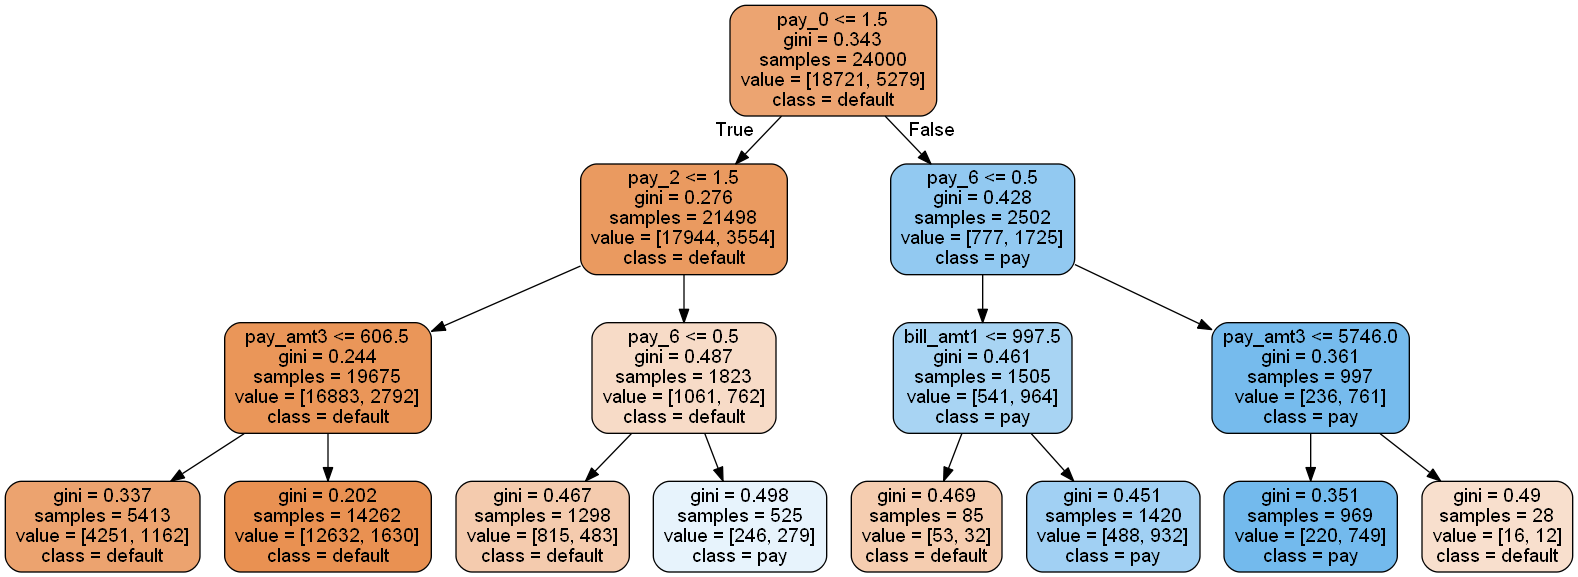

In [12]:
from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont
img = Image.open("default.png")
draw = ImageDraw.Draw(img)
img.save('output.png')
PImage("output.png")

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf.predict(X_test))

0.81733333333333336

In [14]:
y_predicted = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_predicted)
print(metrics.classification_report(y_test, y_predicted))

print(cm)

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      4656
          1       0.67      0.36      0.47      1344

avg / total       0.80      0.82      0.80      6000

[[4414  242]
 [ 854  490]]
